In [1]:
import numpy as np
import synthetic_data as sd
import network_builder as nb
import networkx as nx
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
#from fastdtw import fastdtw
#from dtaidistance import dtw
#from dtaidistance import dtw_visualisation as dtwvis
#from dtaidistance import clustering
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
sns.set()
import random
import pandas as pd
from netCDF4 import Dataset
from stldecompose import decompose, forecast
import folium
import math
import scipy.stats as st

/home/mathsys2/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [198]:
f_pre = Dataset('precipitation.nc')
#f_pre = Dataset('precip.mon.total.v501.nc')

#f_temp = Dataset('temperatureCDC.nc') 
pr = f_pre.variables['precip']
lon = f_pre.variables['lon'][:]
lat = f_pre.variables['lat'][:]
pr = np.swapaxes(pr,0,2)

In [3]:
lat[10], lat[16], lon[16], lon[23]

(13.75, -1.25, 16.25, 33.75)

In [4]:
m = folium.Map(location=[6.25, 25.25],zoom_start = 5)

In [97]:
lat[10]

13.75

In [61]:
np.where(lon == 31.25)[0][0]

22

In [64]:
np.where(lat == 31.25)[0][0]

3

In [235]:
data = pr[10:22,3:11,:]

In [199]:
data = pr[16:23,10:16,:]

In [130]:
data = pr[16:23,16:20,:]

In [236]:
data = unflatten(data)

In [237]:
data = np.swapaxes(data,0,1)

In [238]:
M = data.shape[0]
#data = sd.synthetic_data_generator(M = M)

In [213]:
def deseasonal_STL(data):
    n = data.shape[1]
    N = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        decomp = decompose(data[:,i], period=12)
        data_deseasonal[:,i] = decomp.trend + decomp.resid
    return(data_deseasonal)

In [25]:
data = deseasonal_STL(data)

In [56]:
def deseasonal_monthly_anomaly(data):
    n  = data.shape[1]
    N  = data.shape[0]    
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = data[:,i]
        for j in range(12):
            Idx = np.arange(j,N,12)
            temp[Idx] = temp[Idx] - temp[Idx].mean()
        data_deseasonal[:,i] = temp
    return(data_deseasonal)  

In [53]:
data = deseasonal_Anomaly(data)

In [197]:
def deseasonal_annual_anomaly(data):
    n  = data.shape[1]
    N  = data.shape[0]    
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = data[:,i]
        temp_list = []
        for j in range(0,N,12):   
            temp_list.append(list(temp[j:j+12] - temp[j:j+12].mean()))
            flat_list = [item for sublist in temp_list for item in sublist]
        data_deseasonal[:,i] = np.array(flat_list)
    return(data_deseasonal)

In [194]:
data = deseasonal_annual_anomaly(data)

In [161]:
a = np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,14])

In [159]:
temp = np.empty(3)

In [160]:
temp

array([5.e-324, 5.e-324, 5.e-324])

In [176]:
temp = []
for j in range(0,12,4):
    temp.append(list(a[j:j+4] - a[j:j+4].mean()))

In [177]:
temp

[[-1.5, -0.5, 0.5, 1.5], [-1.5, -0.5, 0.5, 1.5], [-1.5, -0.5, 0.5, 1.5]]

In [178]:
flat_list = [item for sublist in temp for item in sublist]

In [180]:
flat_list

[-1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5, -1.5, -0.5, 0.5, 1.5]

In [114]:
a[0:4] - a[0:4].mean()

array([-1.5, -0.5,  0.5,  1.5])

In [120]:
a

array([-1,  0,  0,  1, -1,  0,  0,  1, -1,  0,  0,  1,  0])

In [82]:
temp = np.arange(0,37)

In [83]:
temp

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

In [84]:
for j in range(12):
    Idx = np.arange(j,len(temp),12)
    temp[Idx] = temp[Idx] - temp[Idx].mean()

In [85]:
temp

array([-18, -12, -12, -12, -12, -12, -12, -12, -12, -12, -12, -12,  -6,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,  12,
        12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  18])

In [91]:
(11+23+35)/3

23.0

In [267]:
r = np.arange(0.1,1,0.05)
p_limit = []
z_limit = []
for i in range(len(r)):
    
    n = data.shape[1]
    m = nb.weighted_matrix(data[:M-2,:])
    m = np.absolute(m)
    # G, c = nb.graph_builder_limit(m, r[i])

    np.fill_diagonal(m, 0)
    Z = abs(np.arctanh(m))
    N = data.shape[0]
    SE = 1/math.sqrt(N-3)
    Z_real = np.arctanh(0)
    Z = (Z-Z_real)/SE
    p = st.norm.cdf(Z)

    adjacency_matrix = np.zeros(m.shape)
    adjacency_matrix[m > r[i]] = 1
    
    p_limit.append(p[adjacency_matrix.astype(int) == 1].min())
    z_limit.append(Z[adjacency_matrix.astype(int) == 1].min())
    
    

ValueError: zero-size array to reduction operation minimum which has no identity

In [275]:
len(p_limit)

15

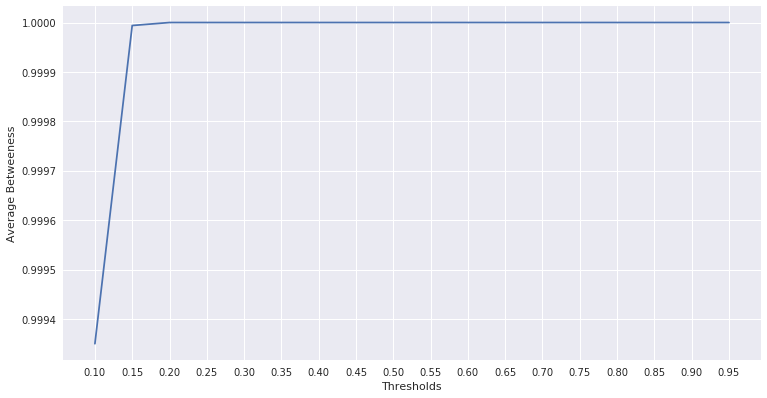

In [262]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Average Betweeness")
plt.xlabel("Thresholds")
plt.plot(r,p_limit);

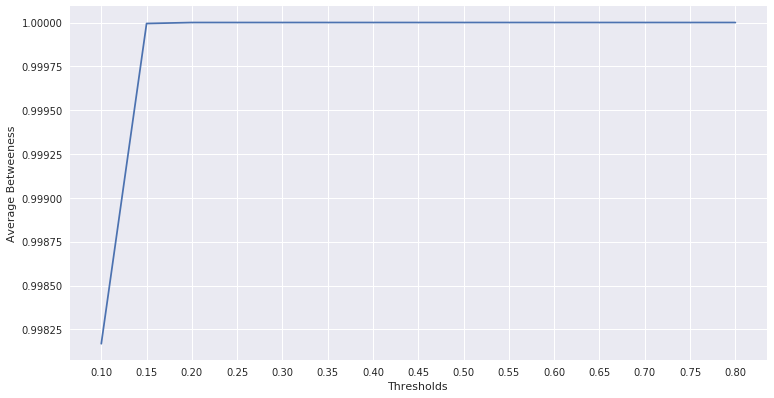

In [276]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Average Betweeness")
plt.xlabel("Thresholds")
plt.plot(r[:15],p_limit);

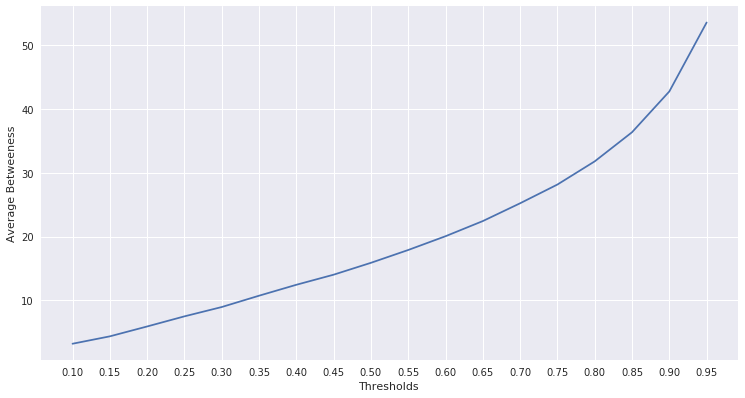

In [263]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Average Betweeness")
plt.xlabel("Thresholds")
plt.plot(r,z_limit);

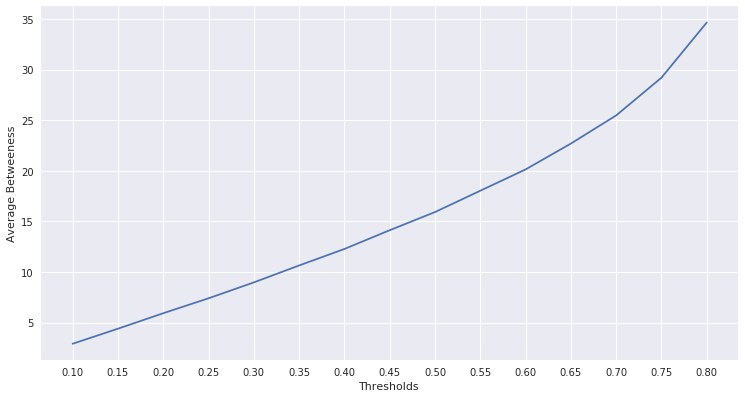

In [277]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Average Betweeness")
plt.xlabel("Thresholds")
plt.plot(r[:15],z_limit)

In [10]:
def unflatten(data):
    result = np.zeros((data.shape[0]*data.shape[1],data.shape[2]))
    r = data.shape[0]
    c = data.shape[1]
    for i in range(r):
        for j in range(c):
            result[i * c + j,:] = data[i,j,:]
    return(result)

In [11]:
def exponential_smoothing(data, alpha):
    n = data.shape[0]
    M = data.shape[1]
    result = np.zeros(M)
    for j in range(M):
        y = data[:,j]
        s = np.zeros(n)
        s[0] = y[0]
        for i in range(1,n):
            s[i] = alpha * y[i-1] + (1-alpha)*s[i-1] 
        result[j] = s[-1]
    return(result)

In [12]:
def feature_extractorNew(G):
    degree = dict(G.degree())
    knn = nx.average_neighbor_degree(G)
    closseness = nx.closeness_centrality(G)
    kcore = dict(nx.core_number(G))
    betweeness= dict(nx.betweenness_centrality(G))
    pagerank = dict(nx.pagerank(G, alpha=0.85))
    #eigenvector = dict(nx.eigenvector_centrality(G, max_iter = 1000))
    eigenvector = dict(nx.eigenvector_centrality_numpy(G))
    
    
    X = []
    for j in range(n):
        if (j in degree.keys()):
            x = []
            x.append(degree[j])
            x.append(knn[j])
            x.append(pagerank[j])
            x.append(nx.clustering(G, j))
            X.append(x)
    return(X)

In [13]:
def feature_extractor(G):
    degree = dict(G.degree())
    closseness = nx.closeness_centrality(G)
    kcore = dict(nx.core_number(G))
    betweeness= dict(nx.betweenness_centrality(G))
    pagerank = dict(nx.pagerank(G, alpha=0.85))
    #eigenvector = dict(nx.eigenvector_centrality(G, max_iter = 1000))
    eigenvector = dict(nx.eigenvector_centrality_numpy(G))
    
    X = []
    for j in range(n):
        if (j in degree.keys()):
            x = []
            x.append(degree[j])
            x.append(closseness[j])
            x.append(kcore[j])
            x.append(betweeness[j])
            x.append(pagerank[j])
            x.append(eigenvector[j])
            x.append(nx.clustering(G, j))
            X.append(x)
    return(X)

In [14]:
def graph_average_calculator(G):
    average_degree = []
    second_moment = []
    variance = []
    shannon_entropy = []
    transitivity_pr = []
    average_cluster= []
    average_shortest_path_length = []
    average_closeness = []
    average_betweennes = []
    average_eigenvector = []
    average_pagerank =  []
    
    degree = dict(G.degree())
    closseness = nx.closeness_centrality(G)
    kcore = dict(nx.core_number(G))
    betweeness= dict(nx.betweenness_centrality(G))
    pagerank = dict(nx.pagerank(G, alpha=0.85))
    eigenvector = dict(nx.eigenvector_centrality(G, max_iter = 1000))
    
    average_degree.append(nb.momment_of_degree_distribution(G,1))                  #First Moment
    second_moment.append(nb.momment_of_degree_distribution(G,2))                   #Second Moment
    variance.append(nb.momment_of_degree_distribution(G,2) - nb.momment_of_degree_distribution(G,1)**2)     #Variance
    shannon_entropy.append(nb.shannon_entropy(G))                                  #Shanon Entropy
    transitivity_pr.append(nx.transitivity(G))                                     #Transitivity 
    average_cluster.append(nx.average_clustering(G))
    if nx.is_connected(G) == True:
        average_shortest_path_length.append(nx.average_shortest_path_length(G))     #Average Shortest Path
    else:
        average_shortest_path_length.append(0)
  
    average_closeness.append(np.mean(list(closseness.values())))                       #Average closeness centrality
    average_betweennes.append(np.mean(list(betweeness.values())))                        #Average betweenness centrality
    average_eigenvector.append(np.mean(list(eigenvector.values())))                      #Average eigenvector centrality
    average_pagerank.append(np.mean(list(pagerank.values())))
    
    return(average_degree,second_moment,variance,shannon_entropy,transitivity_pr,average_cluster,
           average_shortest_path_length, average_closeness, average_betweennes, average_eigenvector,
           average_pagerank)

In [15]:
def graph_builder_limit (weighted_matrix,limit):
    weighted_matrix = np.absolute(weighted_matrix)
    componenets_number = 0
    adjacency_matrix = np.zeros(weighted_matrix.shape)
    adjacency_matrix[weighted_matrix >= limit] = 1
    G = nx.from_numpy_matrix(adjacency_matrix)
    G = G.to_undirected()
    G.remove_edges_from(G.selfloop_edges())
    componenets_number = nx.number_connected_components(G)
    return(G, componenets_number)

In [9]:
data = unflatten(pr)
data = np.swapaxes(data,0,1)
M = data.shape[0]

In [12]:
m = nb.weighted_matrix(data[:M-2,:])
#G, c = nb.graph_builder_limit(m, r[i])

/home/mathsys2/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [18]:
m = np.nan_to_num(m)

In [27]:
m[600]

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
np.where(m != 0)

(array([   9,    9,    9, ..., 1080, 1080, 1080]),
 array([   9,   10,   68, ..., 1078, 1079, 1080]))

In [36]:
m[1080,1078]

0.5683915875736284

# Neural Network with train set

In [59]:
average_degree = []
second_moment = []
variance = []
shannon_entropy = []
transitivity_pr = []
average_cluster= []
average_shortest_path_length = []
average_closeness = []
average_betweennes = []
average_eigenvector = []
average_pagerank =  []
r = np.arange(0.1,1,0.05)
degree = []
R2 = []
MSE = []
density = []
S = []
components = []

clf = MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50,25,10, ), random_state=1)
for i in range(len(r)):
    n = data.shape[1]
    m = nb.weighted_matrix(data[:M-2,:])
    G, c = nb.graph_builder_limit(m, r[i])
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    density.append(2 * G.number_of_edges()/(len(G)*(len(G)-1)))
    S.append(len(max(nx.connected_component_subgraphs(G), key=len)))
    components.append(c)
    
    #average_degree,second_moment,variance,shannon_entropy,transitivity_pr,average_cluster,
    #average_shortest_path_length, average_closeness, average_betweennes, average_eigenvector,
    #average_pagerank = graph_average_calculator(G)
    
    degree = dict(G.degree())
    closseness = nx.closeness_centrality(G)
    kcore = dict(nx.core_number(G))
    betweeness= dict(nx.betweenness_centrality(G))
    pagerank = dict(nx.pagerank(G, alpha=0.85))
    eigenvector = dict(nx.eigenvector_centrality(G, max_iter = 1000))
    
    average_degree.append(nb.momment_of_degree_distribution(G,1))                  #First Moment
    second_moment.append(nb.momment_of_degree_distribution(G,2))                   #Second Moment
    variance.append(nb.momment_of_degree_distribution(G,2) - nb.momment_of_degree_distribution(G,1)**2)     #Variance
    shannon_entropy.append(nb.shannon_entropy(G))                                  #Shanon Entropy
    transitivity_pr.append(nx.transitivity(G))                                     #Transitivity 
    average_cluster.append(nx.average_clustering(G))
    if nx.is_connected(G) == True:
        average_shortest_path_length.append(nx.average_shortest_path_length(G))     #Average Shortest Path
    else:
        average_shortest_path_length.append(0)
  
    average_closeness.append(np.mean(list(closseness.values())))                       #Average closeness centrality
    average_betweennes.append(np.mean(list(betweeness.values())))                        #Average betweenness centrality
    average_eigenvector.append(np.mean(list(eigenvector.values())))                      #Average eigenvector centrality
    average_pagerank.append(np.mean(list(pagerank.values())))
    
    X = feature_extractor(G)        
    Y = data[M-2,:]
    Y_test = data[M-1,:]
    clf.fit(X, Y)
    y = clf.predict(X)
    R2.append(r2_score(Y_test,y))
   # MSE.append(np.mean(np.power(Y_test-y,2)/np.std(data,axis=0)))
    MSE.append(mean_squared_error(Y_test, y))

In [60]:
null = exponential_smoothing(data, 0.1)
error = np.mean(np.power(Y_test-null,2)/np.std(data,axis=0))

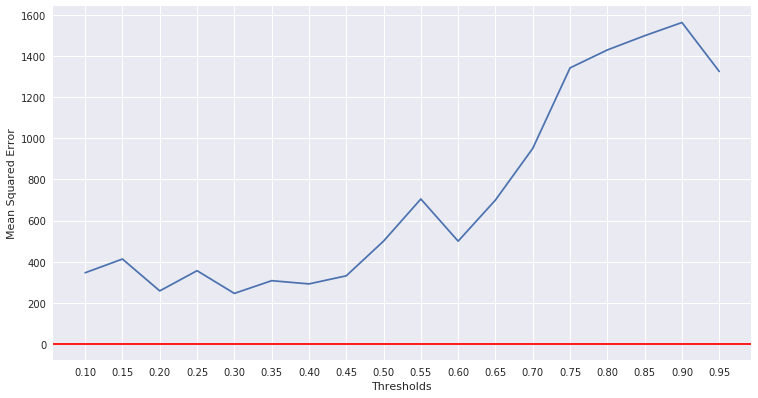

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.ylabel("Mean Squared Error")
plt.xlabel("Thresholds")
plt.xticks(r)
plt.plot(r,MSE)
plt.axhline(y=error, color='r', linestyle='-');

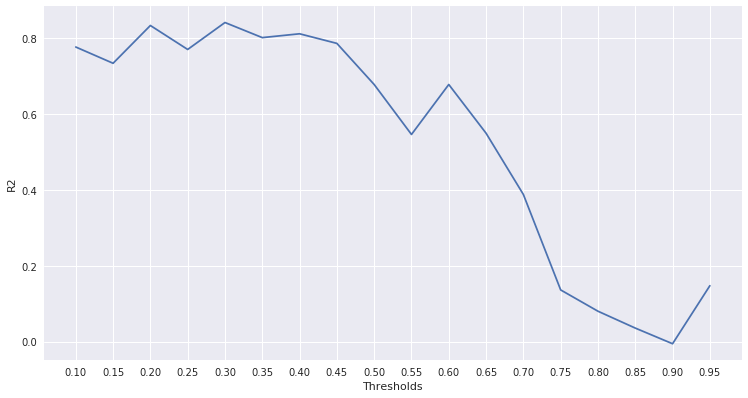

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("R2")
plt.xlabel("Thresholds")
plt.plot(r,R2);

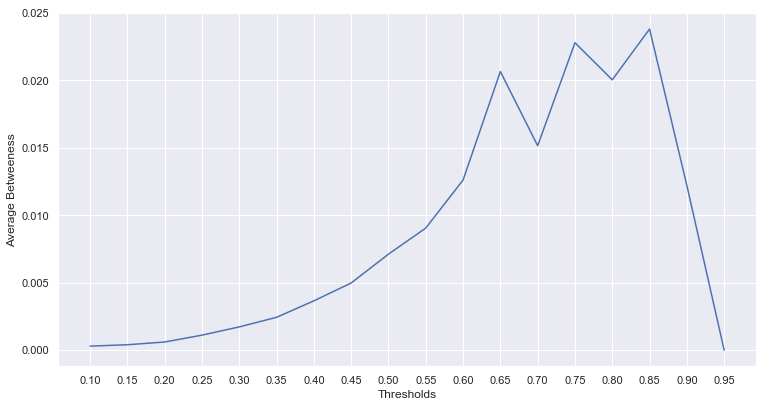

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Average Betweeness")
plt.xlabel("Thresholds")
plt.plot(r,average_betweennes);

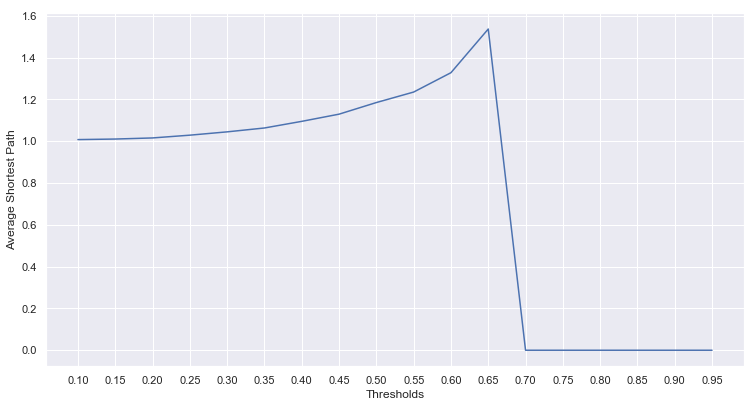

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.ylabel("Average Shortest Path")
plt.xlabel("Thresholds")
plt.xticks(r)
plt.plot(r,average_shortest_path_length);

In [70]:
data = data_deseasonal

# Random Forest with train set

In [103]:
average_degree = []
second_moment = []
variance = []
shannon_entropy = []
transitivity_pr = []
average_cluster= []
average_shortest_path_length = []
average_closeness = []
average_betweennes = []
average_eigenvector = []
average_pagerank =  []
r = np.arange(0.1,1,0.05)
degree = []
R2 = []
MSE = []
density = []
S = []
components = []

regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
for i in range(len(r)):
    n = data.shape[1]
    m = nb.weighted_matrix(data[:M-2,:])
    G, c = nb.graph_builder_limit(m, r[i])
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    density.append(2 * G.number_of_edges()/(len(G)*(len(G)-1)))
    S.append(len(max(nx.connected_component_subgraphs(G), key=len)))
    components.append(c)
    
 #   average_degree,second_moment,variance,shannon_entropy,transitivity_pr,average_cluster,
  #  average_shortest_path_length, average_closeness, average_betweennes, average_eigenvector,
   # average_pagerank = graph_average_calculator(G)
    
    degree = dict(G.degree())
    closseness = nx.closeness_centrality(G)
    kcore = dict(nx.core_number(G))
    betweeness= dict(nx.betweenness_centrality(G))
    pagerank = dict(nx.pagerank(G, alpha=0.85))
    eigenvector = dict(nx.eigenvector_centrality(G, max_iter = 1000))
    
    average_degree.append(nb.momment_of_degree_distribution(G,1))                  #First Moment
    second_moment.append(nb.momment_of_degree_distribution(G,2))                   #Second Moment
    variance.append(nb.momment_of_degree_distribution(G,2) - nb.momment_of_degree_distribution(G,1)**2)     #Variance
    shannon_entropy.append(nb.shannon_entropy(G))                                  #Shanon Entropy
    transitivity_pr.append(nx.transitivity(G))                                     #Transitivity 
    average_cluster.append(nx.average_clustering(G))
    if nx.is_connected(G) == True:
        average_shortest_path_length.append(nx.average_shortest_path_length(G))     #Average Shortest Path
    else:
        average_shortest_path_length.append(0)
  
    average_closeness.append(np.mean(list(closseness.values())))                       #Average closeness centrality
    average_betweennes.append(np.mean(list(betweeness.values())))                        #Average betweenness centrality
    average_eigenvector.append(np.mean(list(eigenvector.values())))                      #Average eigenvector centrality
    average_pagerank.append(np.mean(list(pagerank.values())))
    
    X = feature_extractorNew(G)        
    Y = data[M-2,:]
    Y_test = data[M-1,:]
    regr.fit(X, Y)
    y = regr.predict(X)
    R2.append(r2_score(Y_test,y))
    MSE.append(mean_squared_error(Y_test, y))
    #MSE.append(np.mean(np.power(Y_test-y,2)/np.std(data,axis=0)))
    
    
    

In [104]:
null = exponential_smoothing(data, 0.5)
#error = np.mean(np.power(Y_test-null,2)/np.std(data,axis=0))
error = mean_squared_error(Y_test, null)
null_r2 = r2_score(Y_test, null)

In [88]:
len(decomp.seasonal)

841

In [110]:
np.set_printoptions(suppress=True)

In [112]:
pr[16:23,10:16,-1]

array([[ 0.  ,  0.03,  0.02,  0.11,  2.71, 28.17],
       [ 0.  ,  0.04,  0.17,  1.67, 11.66, 36.88],
       [ 0.  ,  0.  ,  0.79,  9.37, 32.08, 77.05],
       [ 0.  ,  0.  ,  1.7 , 10.09, 27.77, 71.02],
       [ 0.  ,  0.  ,  0.6 ,  7.74, 32.33, 64.3 ],
       [ 0.  ,  0.03,  0.86,  3.62, 27.83, 57.56],
       [ 0.01,  0.  ,  0.6 ,  4.02,  8.44, 18.3 ]], dtype=float32)

In [111]:
Y_test

array([ 0.        ,  0.03      ,  0.02      ,  0.11      ,  2.71000004,
       28.17000008,  0.        ,  0.04      ,  0.17      ,  1.66999996,
       11.65999985, 36.88000107,  0.        ,  0.        ,  0.79000002,
        9.36999989, 32.08000183, 77.05000305,  0.        ,  0.        ,
        1.70000005, 10.09000015, 27.77000046, 71.01999664,  0.        ,
        0.        ,  0.60000002,  7.73999977, 32.33000183, 64.30000305,
        0.        ,  0.03      ,  0.86000001,  3.61999989, 27.82999992,
       57.56000137,  0.01      ,  0.        ,  0.60000002,  4.01999998,
        8.43999958, 18.29999924])

In [106]:
null

array([ 10.69614722,  24.85501224,  44.37256849,  75.40678396,
        90.02529884, 102.50324404,   8.43699236,  29.88834344,
        43.88875601,  64.35138536, 102.03025293, 125.58785506,
        13.0268233 ,  26.35848781,  42.38985438,  67.35946578,
        97.64626616, 149.57349346,  14.81202274,  21.83735787,
        36.19960903,  73.46741246, 100.12196515, 139.99355162,
         8.6698517 ,  17.74142666,  35.62743792,  59.42037105,
        99.90348537, 137.79553555,  13.49407156,  21.83459781,
        32.53268758,  45.83674697,  91.52825639, 119.07353008,
         8.21520177,  25.95723918,  30.06778746,  41.41142823,
        83.51391696, 136.28371408])

In [94]:
y

array([ 0.63984439,  0.63984439,  0.63984439, 23.39804263, 23.39804263,
       46.32590128,  0.63984439,  0.63984439,  0.63984439, 23.39804263,
       23.39804263, 77.63517044,  0.63984439,  0.63984439,  0.63984439,
       23.39804263, 23.39804263, 69.61126447,  0.63984439,  0.63984439,
        0.63984439, 23.39804263, 23.39804263, 77.63517044,  0.63984439,
        0.63984439,  0.63984439, 23.39804263, 23.39804263, 78.28603691,
        0.63984439,  0.63984439,  0.63984439,  0.63984439, 23.39804263,
       78.48291334,  0.63984439,  0.63984439,  0.63984439,  0.63984439,
       23.39804263, 69.32113587])

In [95]:
X

[[34,
  0.8541666666666666,
  34,
  0.0,
  0.022475481444667603,
  0.14896619677952386,
  1.0],
 [35,
  0.8723404255319149,
  34,
  0.00030487804878048775,
  0.02304612367541995,
  0.15270577264169938,
  0.9882352941176471],
 [38,
  0.9318181818181818,
  34,
  0.0022591744593335266,
  0.024807083033620784,
  0.16221355122291697,
  0.9374110953058321],
 [41,
  1.0,
  34,
  0.006661181728854477,
  0.02668523347335287,
  0.16921848217377386,
  0.874390243902439],
 [41,
  1.0,
  34,
  0.006661181728854477,
  0.02668523347335287,
  0.16921848217377383,
  0.874390243902439],
 [18, 0.640625, 18, 0.0, 0.013761542615635133, 0.0738424218560861, 1.0],
 [34,
  0.8541666666666666,
  34,
  0.0,
  0.022475481444667603,
  0.14896619677952389,
  1.0],
 [36,
  0.8913043478260869,
  34,
  0.0008556910569105689,
  0.02362839688728804,
  0.1560199195054651,
  0.9714285714285714],
 [39,
  0.9534883720930233,
  34,
  0.0032275816916242203,
  0.02540951252492343,
  0.16497142926302888,
  0.9190283400809717],


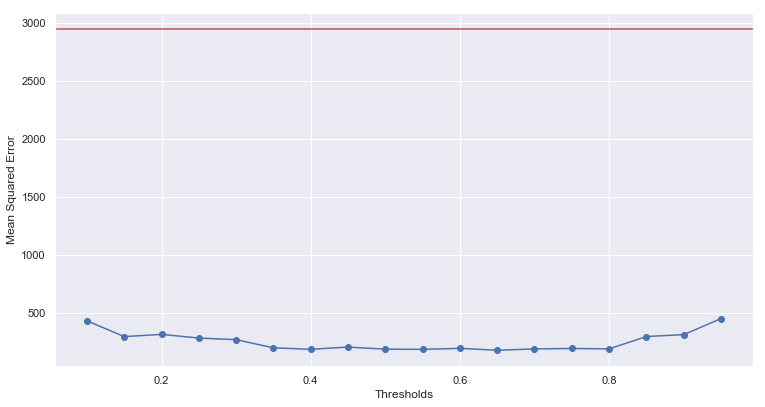

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
#plt.xticks(r)
plt.ylabel("Mean Squared Error")
plt.xlabel("Thresholds")
plt.plot(r,MSE,'-o')
plt.axhline(y=error, color='r', linestyle='-');

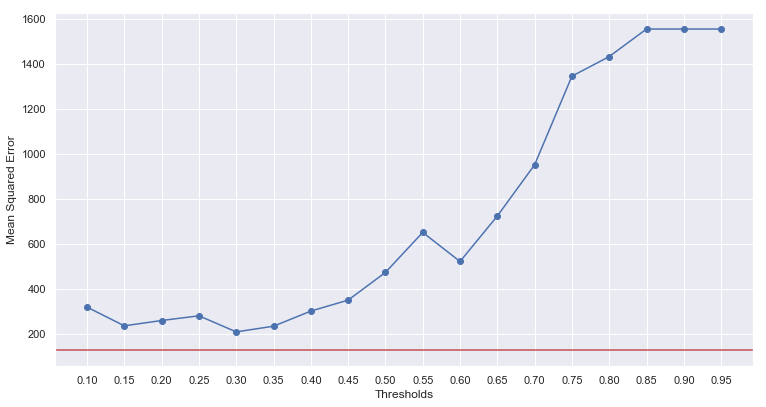

In [80]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Mean Squared Error")
plt.xlabel("Thresholds")
plt.plot(r,MSE,'-o')
plt.axhline(y=error, color='r', linestyle='-');

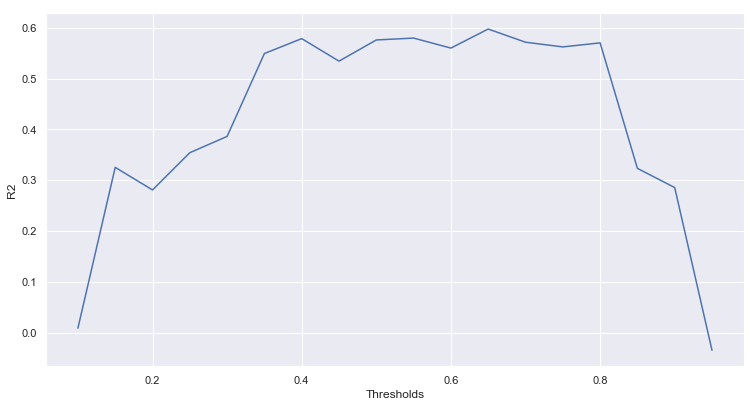

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
#plt.xticks(r)
plt.ylabel("R2")
plt.xlabel("Thresholds")
plt.plot(r,R2);

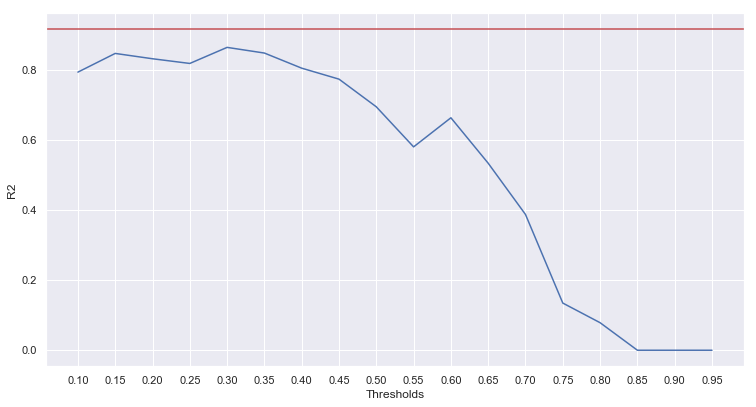

In [79]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("R2")
plt.xlabel("Thresholds")
plt.plot(r,R2)
plt.axhline(y=null_r2, color='r', linestyle='-');

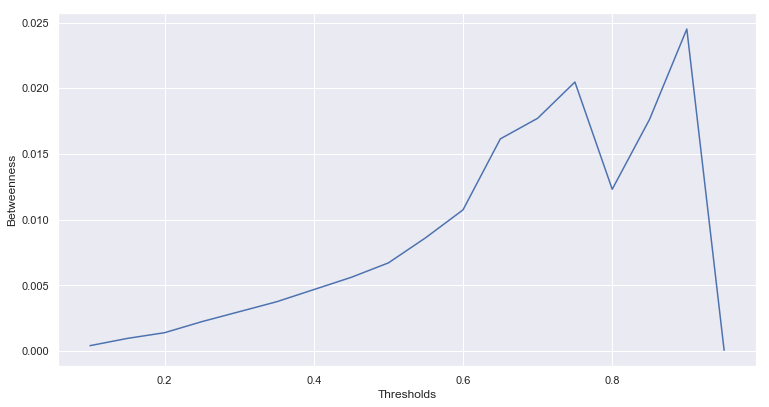

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
#plt.xticks(r)
plt.ylabel("Betweenness")
plt.xlabel("Thresholds")
plt.plot(r,average_betweennes);

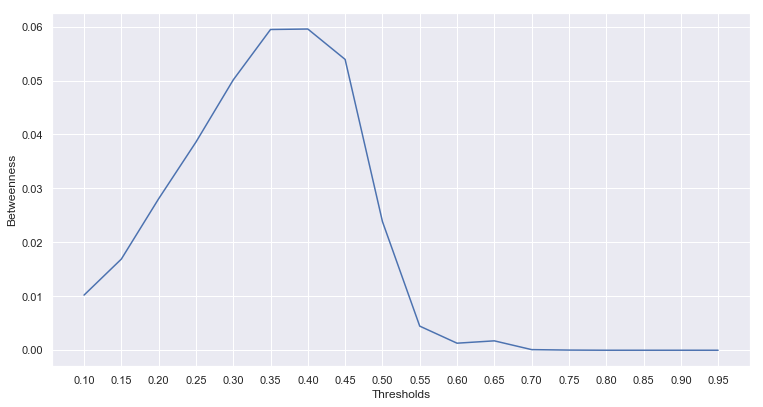

In [78]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Betweenness")
plt.xlabel("Thresholds")
plt.plot(r,average_betweennes);

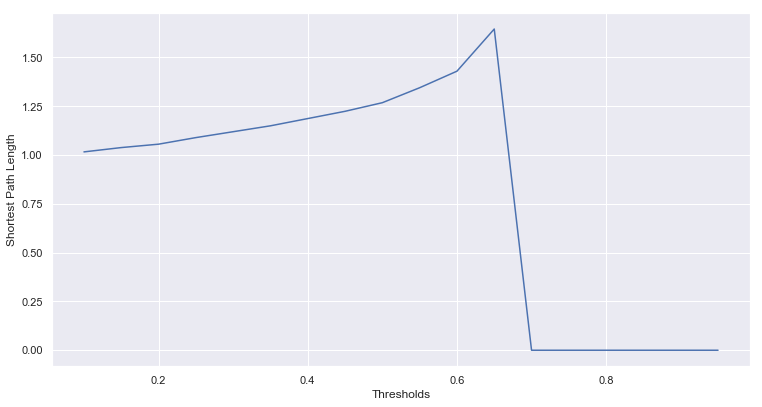

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
#plt.xticks(r)
plt.ylabel("Shortest Path Length")
plt.xlabel("Thresholds")
plt.plot(r,average_shortest_path_length);

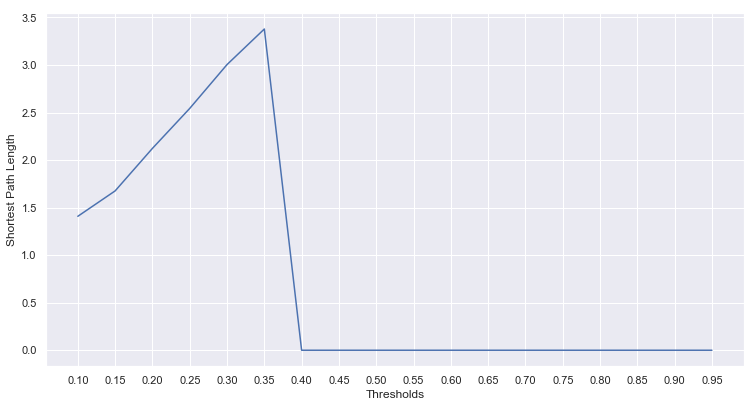

In [77]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Shortest Path Length")
plt.xlabel("Thresholds")
plt.plot(r,average_shortest_path_length);

In [64]:
data = deseasonal_Anomaly(data)

In [203]:
data = deseasonal_annual_anomaly(data)

In [225]:
data = deseasonal_STL(data)

# Linear Regression

In [239]:
average_degree = []
second_moment = []
variance = []
shannon_entropy = []
transitivity_pr = []
average_cluster= []
average_shortest_path_length = []
average_closeness = []
average_betweennes = []
average_eigenvector = []
average_pagerank =  []
r = np.arange(0.1,1,0.05)
degree = []
R2 = []
MSE = []
components = []
density = []
S = []
degree = []
average_degree = []
second_moment = []
variance = []
shannon_entropy = []
transitivity_pr = []
average_cluster= []
average_shortest_path_length = []
average_closeness = []
average_betweennes = []
average_eigenvector = []
average_pagerank =  []
regr = linear_model.LinearRegression()
for i in range(len(r)):
    n = data.shape[1]
    m = nb.weighted_matrix(data[:M-2,:])
    G, c = nb.graph_builder_limit(m, r[i])
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    density.append(1 - (2 * G.number_of_edges()/(len(G)*(len(G)-1))))
    S.append(len(max(nx.connected_component_subgraphs(G), key=len)))
    components.append(c)
    
    #average_degree,second_moment,variance,shannon_entropy,transitivity_pr,average_cluster,
    #average_shortest_path_length, average_closeness, average_betweennes, average_eigenvector,
    #average_pagerank = graph_average_calculator(G)
    degree = dict(G.degree())
    closseness = nx.closeness_centrality(G)
    kcore = dict(nx.core_number(G))
    betweeness= dict(nx.betweenness_centrality(G))
    pagerank = dict(nx.pagerank(G, alpha=0.85))
    #eigenvector = dict(nx.eigenvector_centrality(G, max_iter = 1000))
    eigenvector = dict(nx.eigenvector_centrality_numpy(G))
    
    average_degree.append(nb.momment_of_degree_distribution(G,1))                  #First Moment
    second_moment.append(nb.momment_of_degree_distribution(G,2))                   #Second Moment
    variance.append(nb.momment_of_degree_distribution(G,2) - nb.momment_of_degree_distribution(G,1)**2)     #Variance
    shannon_entropy.append(nb.shannon_entropy(G))                                  #Shanon Entropy
    transitivity_pr.append(nx.transitivity(G))                                     #Transitivity 
    average_cluster.append(nx.average_clustering(G))
    if nx.is_connected(G) == True:
        average_shortest_path_length.append(nx.average_shortest_path_length(G))     #Average Shortest Path
    else:
        average_shortest_path_length.append(0)
  
    average_closeness.append(np.mean(list(closseness.values())))                       #Average closeness centrality
    average_betweennes.append(np.mean(list(betweeness.values())))                        #Average betweenness centrality
    average_eigenvector.append(np.mean(list(eigenvector.values())))                      #Average eigenvector centrality
    average_pagerank.append(np.mean(list(pagerank.values())))
    
    X = feature_extractor(G)        
    Y = data[M-2,:]
    Y_test = data[M-1,:]
    regr.fit(X, Y)
    y = regr.predict(X)
    R2.append(r2_score(Y_test,y))
    MSE.append(mean_squared_error(Y_test, y))
    #MSE.append(np.mean(np.power(Y_test-y,2)/np.std(data,axis=0)))

In [227]:
null = exponential_smoothing(data, 0.5)
error = mean_squared_error(Y_test, null)
null_r2 = r2_score(Y_test, null)

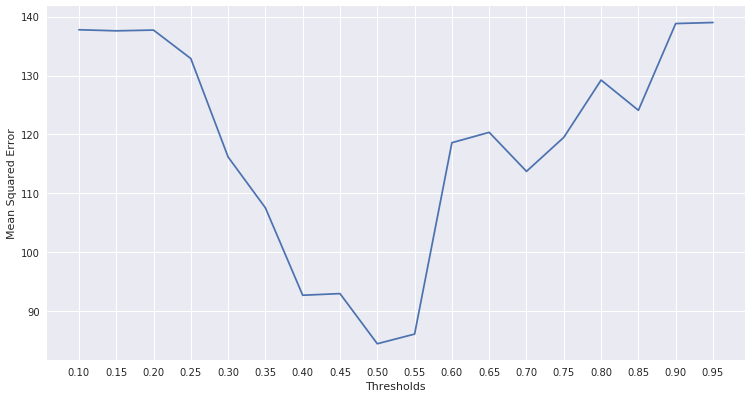

In [220]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Mean Squared Error")
plt.xlabel("Thresholds")
plt.plot(r,MSE);
#plt.axhline(y=error, color='r', linestyle='-');

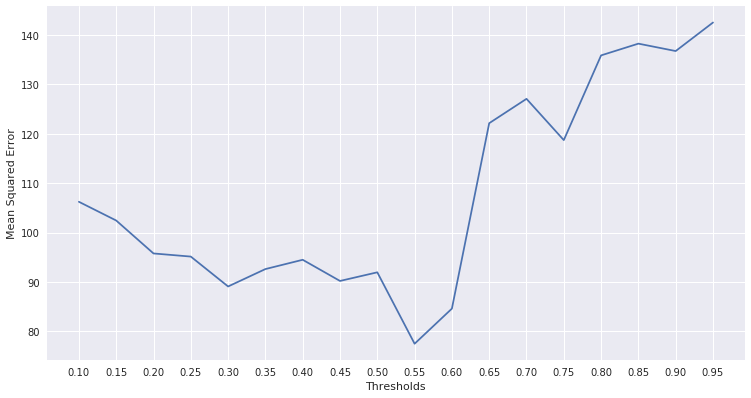

In [228]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Mean Squared Error")
plt.xlabel("Thresholds")
plt.plot(r,MSE);
#plt.axhline(y=error, color='r', linestyle='-');

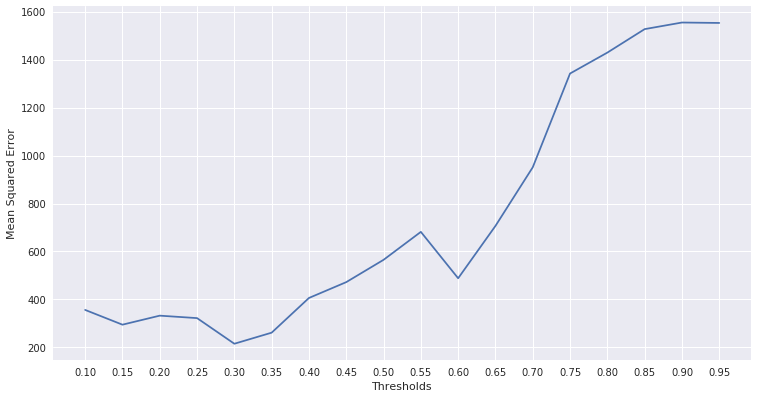

In [230]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Mean Squared Error")
plt.xlabel("Thresholds")
plt.plot(r,MSE);
#plt.axhline(y=error, color='r', linestyle='-');

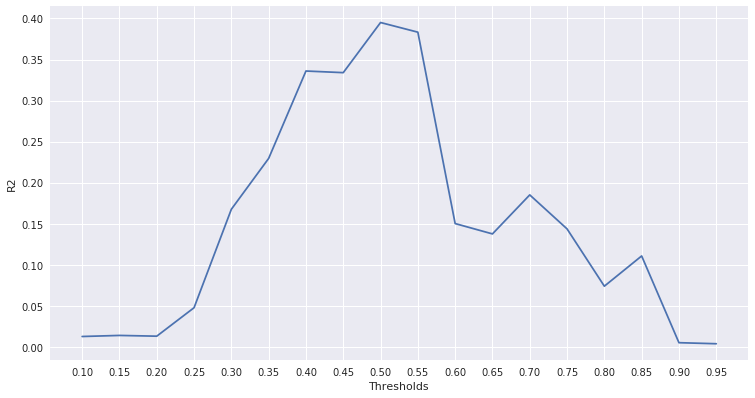

In [221]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("R2")
plt.xlabel("Thresholds")
plt.plot(r,R2);
#plt.axhline(y=null_r2, color='r', linestyle='-');

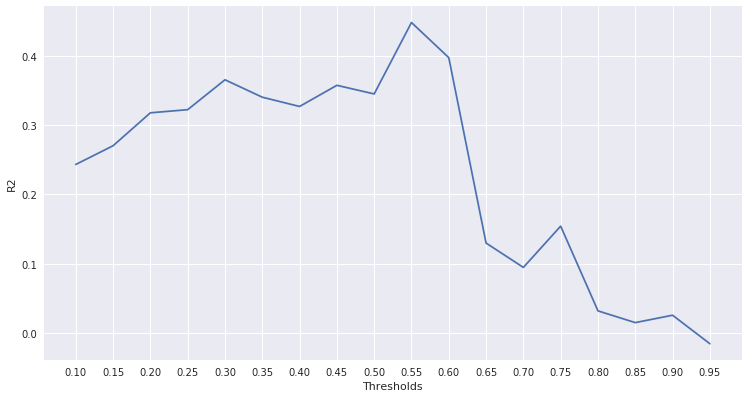

In [229]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("R2")
plt.xlabel("Thresholds")
plt.plot(r,R2);
#plt.axhline(y=null_r2, color='r', linestyle='-');

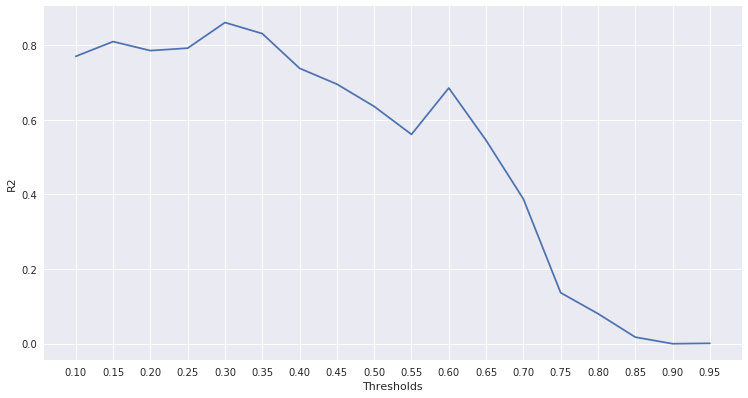

In [231]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("R2")
plt.xlabel("Thresholds")
plt.plot(r,R2);
#plt.axhline(y=null_r2, color='r', linestyle='-');

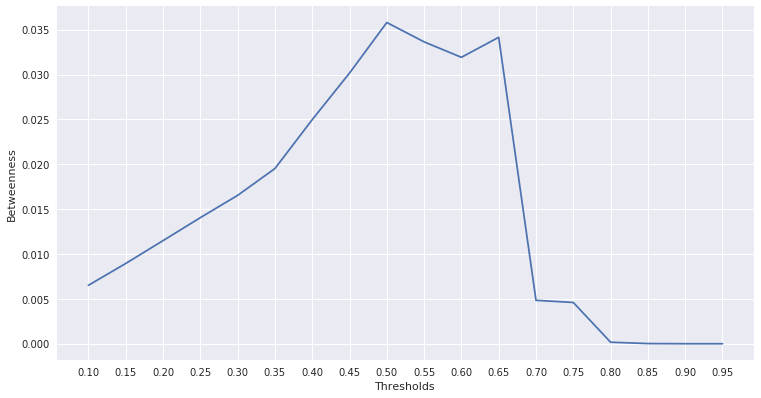

In [230]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Betweenness")
plt.xlabel("Thresholds")
plt.plot(r,average_betweennes);

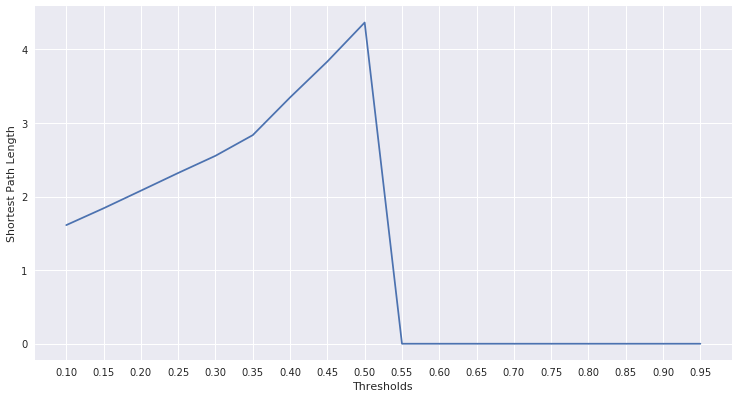

In [231]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Shortest Path Length")
plt.xlabel("Thresholds")
plt.plot(r,average_shortest_path_length);

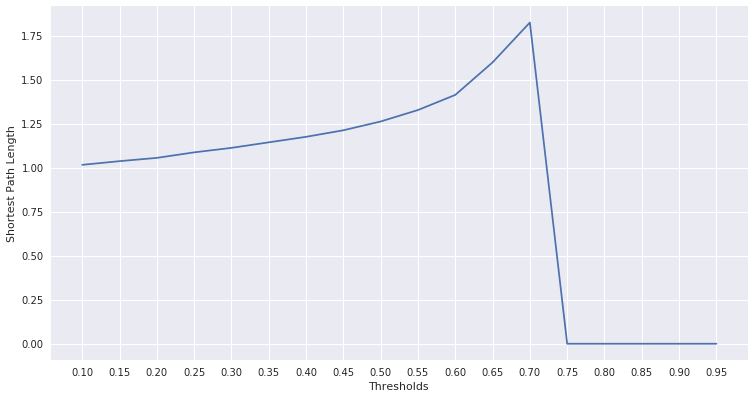

In [208]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Shortest Path Length")
plt.xlabel("Thresholds")
plt.plot(r,average_shortest_path_length);

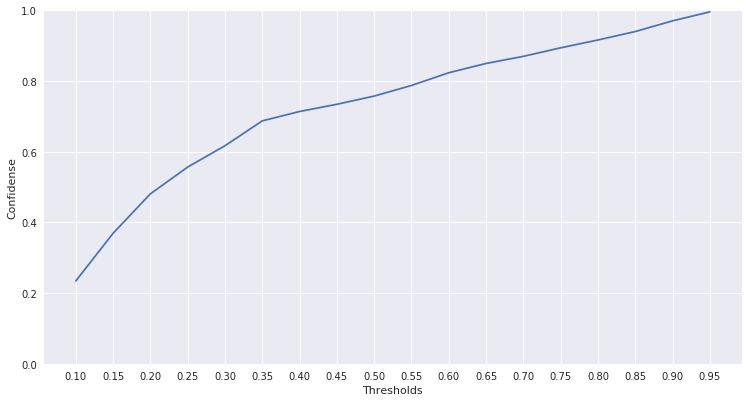

In [240]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Confidense")
plt.xlabel("Thresholds")
ax.set_ylim(ymin=0)
plt.plot(r,density);

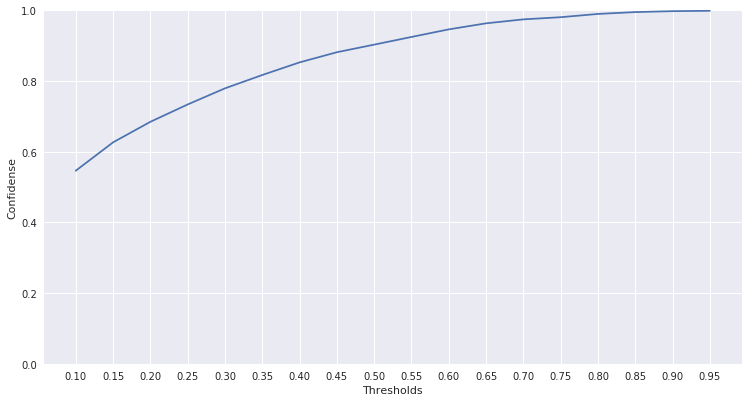

In [233]:
fig, ax = plt.subplots()
fig.set_size_inches(12.5, 6.5)
plt.xticks(r)
plt.ylabel("Confidense")
plt.xlabel("Thresholds")
ax.set_ylim(ymin=0)
plt.plot(r,density);

In [93]:
average_degree = []
second_moment = []
variance = []
shannon_entropy = []
transitivity_pr = []
average_cluster= []
average_shortest_path_length = []
average_closeness = []
average_betweennes = []
average_eigenvector = []
average_pagerank =  []
r = np.arange(0.1,1,0.05)
degree = []
R2 = []
MSE = []
density = []
S = []
components = []

regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)

n = data.shape[1]
m = nb.weighted_matrix(data[:M-2,:])
G, c = nb.graph_builder_limit(m, 0.3)
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
density.append(2 * G.number_of_edges()/(len(G)*(len(G)-1)))
S.append(len(max(nx.connected_component_subgraphs(G), key=len)))
components.append(c)

#   average_degree,second_moment,variance,shannon_entropy,transitivity_pr,average_cluster,
#  average_shortest_path_length, average_closeness, average_betweennes, average_eigenvector,
# average_pagerank = graph_average_calculator(G)

degree = dict(G.degree())
closseness = nx.closeness_centrality(G)
kcore = dict(nx.core_number(G))
betweeness= dict(nx.betweenness_centrality(G))
pagerank = dict(nx.pagerank(G, alpha=0.9))
eigenvector = dict(nx.eigenvector_centrality(G, max_iter = 1000))

average_degree.append(nb.momment_of_degree_distribution(G,1))                  #First Moment
second_moment.append(nb.momment_of_degree_distribution(G,2))                   #Second Moment
variance.append(nb.momment_of_degree_distribution(G,2) - nb.momment_of_degree_distribution(G,1)**2)     #Variance
shannon_entropy.append(nb.shannon_entropy(G))                                  #Shanon Entropy
transitivity_pr.append(nx.transitivity(G))                                     #Transitivity 
average_cluster.append(nx.average_clustering(G))
if nx.is_connected(G) == True:
    average_shortest_path_length.append(nx.average_shortest_path_length(G))     #Average Shortest Path
else:
    average_shortest_path_length.append(0)

average_closeness.append(np.mean(list(closseness.values())))                       #Average closeness centrality
average_betweennes.append(np.mean(list(betweeness.values())))                        #Average betweenness centrality
average_eigenvector.append(np.mean(list(eigenvector.values())))                      #Average eigenvector centrality
average_pagerank.append(np.mean(list(pagerank.values())))

X = feature_extractor(G)        
Y = data[M-2,:]
Y_test = data[M-1,:]
regr.fit(X, Y)
y = regr.predict(X)
R2.append(r2_score(Y_test,y))
MSE.append(mean_squared_error(Y, y))
#MSE.append(np.mean(np.power(Y_test-y,2)/np.std(data,axis=0)))

In [165]:
np.std(data,axis=0)

array([ 48.2212521 ,  77.0549924 , 101.20671704, 101.13459907,
        74.98530447,  58.86950563,  52.32502106,  81.2923667 ,
        98.34804061,  92.63821121,  68.28793819,  55.50365972,
        63.32387348,  79.73295009,  91.86908489,  92.15032903,
        70.28356286,  52.77371599,  63.78561857,  70.07779138,
        81.62767178,  94.18346089,  72.03553514,  53.70434175,
        39.57335477,  57.23329428,  87.69222267,  84.46873678,
        76.00590948,  60.11857671,  40.11307959,  57.15520593,
        79.08213296,  75.95948982,  72.67456156,  47.41537431,
        39.86695078,  61.96450555,  71.27692553,  63.60771107,
        65.23709177,  48.9656701 ])

In [166]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = {0:'degree',1:'closseness',2:'kcore',3:'betweeness',4:'pagerank', 5:'eigenvector',6:'clustering'}
featuresNew = {0:'degree',1:'average neighbour degree',2:'pagerank',3:'clustering'}
# Print the feature ranking
print("Feature ranking:")

for f in range(len(X[1])):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. closseness (0.493592)
2. kcore (0.203290)
3. eigenvector (0.149785)
4. degree (0.084042)
5. clustering (0.038277)
6. pagerank (0.025142)
7. betweeness (0.005871)


In [44]:
R2_RF = np.load("R2_RF.npy")
r = np.arange(0.1,1,0.05)
r = np.arange(0.1,1,0.01)

In [45]:
R2_RF

array([0.99999697, 0.99998147, 0.99994402, 0.99986195, 0.99979992,
       0.99976361, 0.99965808, 0.9962181 , 0.99620643, 0.99622225,
       0.99622225, 0.99621848, 0.99622451, 0.99621848, 0.99620266,
       0.99620002, 0.996217  , 0.99619856, 0.9961895 , 0.99619666,
       0.99592462, 0.99245209, 0.99238787, 0.99238744, 0.99243146,
       0.99222795, 0.99222345, 0.98870434, 0.98869093, 0.98869093,
       0.98868979, 0.98868905, 0.98870881, 0.98858975, 0.98861395,
       0.98858975, 0.98858975, 0.98869431, 0.98869431, 0.98869431,
       0.98499981, 0.98497313, 0.98497313, 0.98500279, 0.97760271,
       0.97760271, 0.97758946, 0.97760124, 0.97026514, 0.96662089,
       0.96299345, 0.96298217, 0.95937911, 0.95578173, 0.95220092,
       0.9486351 , 0.94863439, 0.93449148, 0.9275298 , 0.92063961,
       0.89688032, 0.8902509 , 0.88694647, 0.87707711, 0.84514227,
       0.82050822, 0.80252064, 0.77065899, 0.75660069, 0.71335768,
       0.6876034 , 0.65547956, 0.62480357, 0.59326021, 0.55275

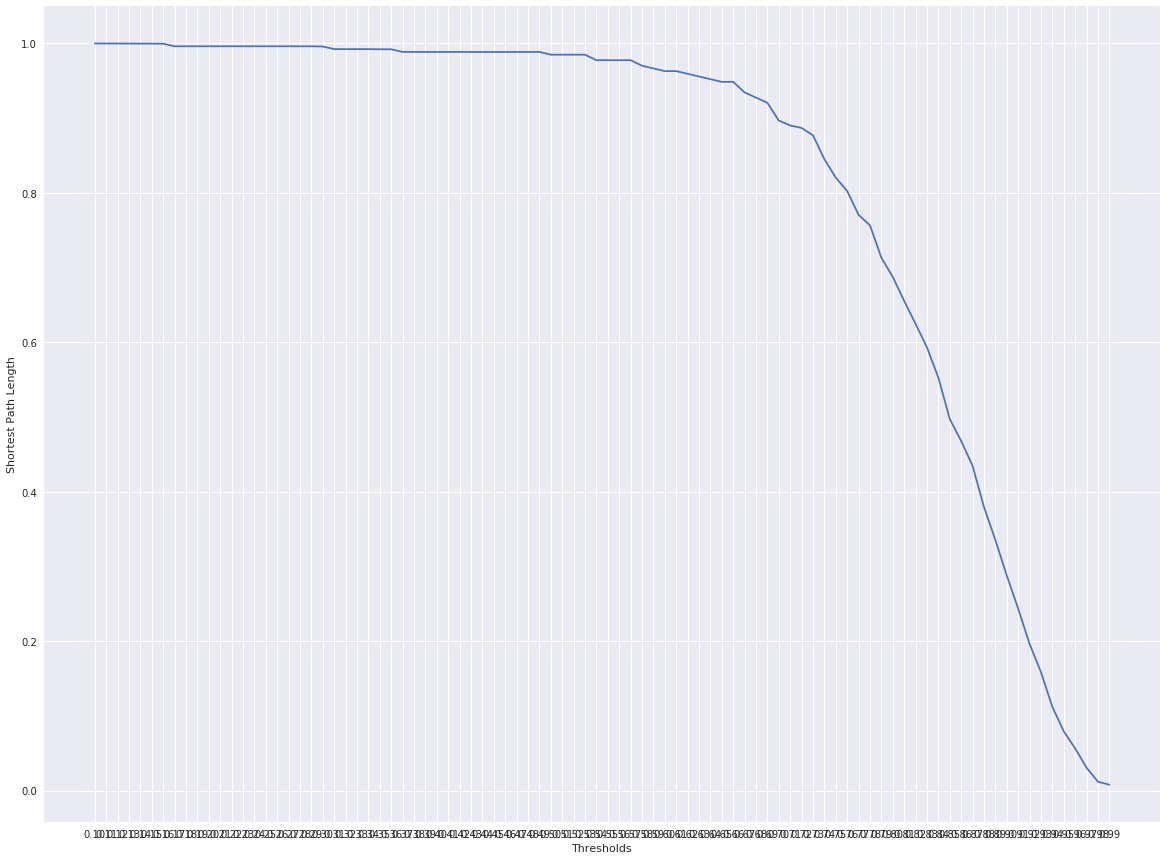

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
plt.xticks(r)
plt.ylabel("Shortest Path Length")
plt.xlabel("Thresholds")
plt.plot(r,R2_RF);

In [ ]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50, 25, 10, ), random_state=1)


In [63]:
X = []
for i in range(n):
    if (i in degree.keys()):
        x = []
        #x.append(i)
        x.append(degree[i])
        x.append(closseness[i])
        x.append(kcore[i])
        x.append(betweeness[i])
        x.append(pagerank[i])
        x.append(eigenvector[i])
        x.append(nx.clustering(G, i))
        X.append(x)

In [64]:
Y = data[999,:]

In [59]:
clf.fit(X, Y)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 25, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [65]:
y = clf.predict(X)

In [ ]:
r = np.arange(0.1,1,0.05)
components = []
density = []
S = []
degree = []
R2 = []
MSE = []

clf = MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50,20, ), random_state=1)
for i in range(len(r)):
    n = data.shape[1]
    m = nb.weighted_matrix(data[:M-301,:])
    G, c = nb.graph_builder_limit(m, r[i])
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    
    density.append(2 * G.number_of_edges()/(len(G)*(len(G)-1)))
    S.append(len(max(nx.connected_component_subgraphs(G), key=len)))
    components.append(c)

    X = feature_extractor(G)           
    Y = data[M-301,:]
    clf.fit(X, Y)
    
    m = nb.weighted_matrix(data[M-300:M-1,:])
    G_test, c = nb.graph_builder_limit(m, r[i])
    G_test = G_test.to_undirected()
    G_test.remove_edges_from(nx.selfloop_edges(G_test))
    
    X_test = feature_extractor(G_test)
    average_degree,second_moment,variance,shannon_entropy,transitivity_pr,average_cluster,
    average_shortest_path_length, average_closeness, average_betweennes, average_eigenvector,
    average_pagerank = graph_average_calculator(G)
    
    
    Y_test = data[M-1,:]
    y_pred = clf.predict(X_test)
    R2.append(r2_score(Y_test,y_pred))
    MSE.append(mean_squared_error(Y_test,y_pred))

In [44]:
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
regr.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [45]:
y = regr.predict(X)

In [33]:
r2_score(Y,y) #0.7

0.23477677804210784

In [39]:
r2_score(Y,y) #0.5

0.2398545888861583

In [46]:
r2_score(Y,y) #0.3

0.19948335276926576

In [ ]:
import numpy.ma as ma
import math
import numpy as np
from netCDF4 import Dataset
from scipy import stats
import networkx as nx
import pandas as pd


f_temp = Dataset('temp0818.nc')
f_pre = Dataset('pre0818.nc')

air = f_temp.variables['air']
pr_wtr = f_pre.variables['pr_wtr']

N = f_temp['time'].shape[0]

air = np.flip(air, 1)
pr_wtr = np.flip(pr_wtr, 1)

f_spei = Dataset('spei12.nc')
spei_data = f_spei.variables['spei']

def weighted_matrix(data, spei_data):
    lat_number = data.shape[1]
    lon_number = data.shape[2]
    N = lat_number * lon_number
    pearson_r = np.zeros((N,N))
    
    for i in range(N):
        lat_index = math.floor(i/lon_number)
        lon_index = i%lon_number
        if ma.is_masked(data[-1,lat_index ,lon_index]) or np.isnan(spei_data[-1,lat_index,lon_index]): 
            pearson_r[i,:] = np.nan
            continue;
        for j in range(N):
            lat_index_sec = math.floor(j/lon_number)
            lon_index_sec = j%lon_number
            if ma.is_masked(data[-1,lat_index_sec ,lon_index_sec]) or np.isnan(spei_data[-1,lat_index_sec,lon_index_sec]) or data[-1,lat_index_sec ,lon_index_sec]==-9.96921e+36:
                pearson_r[i,j] = np.nan
            else:
                pearson_r[i,j] = stats.pearsonr(data[:,lat_index ,lon_index],data[:,lat_index_sec ,lon_index_sec])[0]
                
    new = int(math.sqrt((pearson_r.shape[0] * pearson_r.shape[1]) - np.count_nonzero(np.isnan(pearson_r))))
    pearson_r_clean = pearson_r[~np.isnan(pearson_r)].reshape((new,new))
    return(pearson_r, pearson_r_clean)

def graph_builder (weighted_matrix):
    weighted_matrix = np.exp(-np.sqrt(1 - weighted_matrix))
    componenets_number = 0
    limit = 1.0
    while componenets_number != 1:
        limit -= 0.01
        adjacency_matrix = np.zeros(weighted_matrix.shape)
        adjacency_matrix[weighted_matrix >= limit] = 1
        G = nx.from_numpy_matrix(adjacency_matrix)
        G = G.to_undirected()
        Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        componenets_number = len(Gcc)
    return(G)

def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values()) # we get only the degree values
    maxk = np.max(vk)
    mink = np.min(min)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

def momment_of_degree_distribution(G,m):
    k,Pk = degree_distribution(G)
    M = sum((k**m)*Pk)
    return M

def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H


curr_year = 2008
spei_start = 1295

year = []
average_degree_pr = []
second_moment_pr = []
variance_pr = []
shannon_entropy_pr = []
transitivity_pr = []
average_cluster_pr = []
average_shortest_path_length_pr = []
diameter_pr = []
global_efficiency_pr = []
local_efficiency_pr = []
average_closeness_pr = []
average_betweennes_pr = []
average_eigenvector_pr = []
average_pagerank_pr = []
assortativity_pr = []

average_degree_air = []
second_moment_air = []
variance_air = []
shannon_entropy_air = []
transitivity_air = []
average_cluster_air = []
average_shortest_path_length_air = []
diameter_air = []
global_efficiency_air = []
local_efficiency_air = []
average_closeness_air = []
average_betweennes_air = []
average_eigenvector_air = []
average_pagerank_air = []
assortativity_air = []

lon = np.arange(-40.0,72.0,2.5)
lat = np.arange(-50.0,51.0,2.5)
X = []
lat_number = len(lat)
lon_number = len(lon)

for z in range(math.floor(N/365)):
    
    spei = np.zeros((lat_number,lon_number))
    for i in range(79,280,5):
        for j in range(279,500,5):
            lat_index = int((i-79)/5)
            lon_index = int((j-279)/5)
            spei_index = spei_start + z*12
            if ma.is_masked(spei_data[-1,i,j]) or ma.is_masked(spei_data[-1,i,j+1]) or ma.is_masked(spei_data[-1,i+1,j]) or ma.is_masked(spei_data[-1,i+1,j+1]):
                spei[lat_index,lon_index]= np.nan
            else:
                spei[lat_index,lon_index] = (np.mean(spei_data[spei_index:spei_index + 12,i,j]) + np.mean(spei_data[spei_index:spei_index + 12,i,j+1]) 
                                           + np.mean(spei_data[spei_index:spei_index + 12,i+1,j]) + np.mean(spei_data[spei_index:spei_index + 12,i+1,j+1]))/4
    
    pr_matrix, pr_weighted_matrix = weighted_matrix(pr_wtr[z*365:z*365 + 365,:,:], spei_data)
       
    G_pr = graph_builder(pr_weighted_matrix)
    G_pr = G_pr.to_undirected()
    G_pr.remove_edges_from(nx.selfloop_edges(G_pr))
    
    vk_pr = dict(G_pr.degree())
    CLC_pr = nx.closeness_centrality(G_pr)
    KC_pr = dict(nx.core_number(G_pr))
    B_pr = dict(nx.betweenness_centrality(G_pr))
    PR_pr = dict(nx.pagerank(G_pr, alpha=0.85))
    EC_pr = dict(nx.eigenvector_centrality(G_pr, max_iter = 1000))
                  
    year.append(curr_year)
    
    average_degree_pr.append(momment_of_degree_distribution(G_pr,1))                  #First Moment
    second_moment_pr.append(momment_of_degree_distribution(G_pr,2))                   #Second Moment
    variance_pr.append(momment_of_degree_distribution(G_pr,2) - momment_of_degree_distribution(G_pr,1)**2)     #Variance
    shannon_entropy_pr.append(shannon_entropy(G_pr))                                  #Shanon Entropy
    transitivity_pr.append(nx.transitivity(G_pr))                                     #Transitivity 
    average_cluster_pr.append(nx.average_clustering(G_pr))
    #if nx.is_connected(G_pr) == True:
    average_shortest_path_length_pr.append(nx.average_shortest_path_length(G_pr))     #Average Shortest Path
    diameter_pr.append(nx.diameter(G_pr))                                             #Diameter   
    global_efficiency_pr.append(nx.global_efficiency(G_pr))                           #Efficiency
    local_efficiency_pr.append(nx.local_efficiency(G_pr))                             #Average Local Efficiency  
    average_closeness_pr.append(np.mean(list(CLC_pr.values())))                       #Average closeness centrality
    average_betweennes_pr.append(np.mean(list(B_pr.values())))                        #Average betweenness centrality
    average_eigenvector_pr.append(np.mean(list(EC_pr.values())))                      #Average eigenvector centrality
    average_pagerank_pr.append(np.mean(list(PR_pr.values())))                         #Average PageRank Centrality
    assortativity_pr.append(nx.degree_assortativity_coefficient(G_pr))                #Assortativity
    
    
    air_matrix, air_weighted_matrix = weighted_matrix(air[z*365:z*365 + 365,:,:], spei_data)
    
    G_air = graph_builder(air_weighted_matrix)
    G_air = G_air.to_undirected()
    G_air.remove_edges_from(nx.selfloop_edges(G_air))
    
    vk_air = dict(G_air.degree())
    CLC_air = nx.closeness_centrality(G_air)
    KC_air = dict(nx.core_number(G_air))
    B_air = dict(nx.betweenness_centrality(G_air))
    PR_air = dict(nx.pagerank(G_air, alpha=0.85))
    EC_air = dict(nx.eigenvector_centrality(G_air, max_iter = 1000))
                  
    average_degree_air.append(momment_of_degree_distribution(G_air,1))                  #First Moment
    second_moment_air.append(momment_of_degree_distribution(G_air,2))                   #Second Moment
    variance_air.append(momment_of_degree_distribution(G_air,2) - momment_of_degree_distribution(G_air,1)**2)     #Variance
    shannon_entropy_air.append(shannon_entropy(G_air))                                  #Shanon Entropy
    transitivity_air.append(nx.transitivity(G_air))                                     #Transitivity 
    average_cluster_air.append(nx.average_clustering(G_air))
    #if nx.is_connected(G_air) == True:
    average_shortest_path_length_air.append(nx.average_shortest_path_length(G_air))     #Average Shortest Path
    diameter_air.append(nx.diameter(G_air))                                             #Diameter   
    global_efficiency_air.append(nx.global_efficiency(G_air))                           #Efficiency
    local_efficiency_air.append(nx.local_efficiency(G_air))                             #Average Local Efficiency fficiency  
    average_closeness_air.append(np.mean(list(CLC_air.values())))          #Average closeness centrality
    average_betweennes_air.append(np.mean(list(B_air.values())))           #Average betweenness centrality
    average_eigenvector_air.append(np.mean(list(EC_air.values())))         #Average eigenvector centrality
    average_pagerank_air.append(np.mean(list(PR_air.values())))
    assortativity_air.append(nx.degree_assortativity_coefficient(G_air))                    #Assortativity   
    
    rows,cols = np.where(~np.isnan(pr_matrix))
    nodes = np.unique(rows)
    for i in range(np.unique(rows).shape[0]):
        lat_index = math.floor(nodes[i]/lon_number)
        lon_index = nodes[i] % lon_number
        if (i in vk_pr.keys()) and (np.count_nonzero(np.isnan(spei[:,lat_index,lon_index])) == 0):
            x = []
            x.append(curr_year)
            x.append(lat_index)
            x.append(lon_index)
            x.append(vk_air[i])
            x.append(CLC_air[i])
            x.append(KC_air[i])
            x.append(B_air[i])
            x.append(PR_air[i])
            x.append(EC_air[i])
            x.append(nx.clustering(G_air, i))
            x.append(vk_pr[i])
            x.append(CLC_pr[i])
            x.append(KC_pr[i])
            x.append(B_pr[i])
            x.append(PR_pr[i])
            x.append(EC_pr[i])
            x.append(nx.clustering(G_pr, i))
            for k in range(13):
                x.append(spei[k,lat_index,lon_index])
            X.append(x)
                
    curr_year += 1

df_X = pd.DataFrame(X,columns=['year','lat','lon','vk_air','CLC_air','KC_air','B_air','PR_air','EC_air','clustering_air',
                                'vk_pr','CLC_pr','KC_pr','B_pr','PR_pr','EC_pr','clustering_pr','SPEI'])
    
df_pr = pd.DataFrame(list(zip(year, average_degree_pr, second_moment_pr, variance_pr, shannon_entropy_pr, transitivity_pr,
                           average_cluster_pr, average_closeness_pr, average_betweennes_pr, average_eigenvector_pr,
                           average_pagerank_pr, assortativity_pr,average_shortest_path_length_pr,diameter_pr,global_efficiency_pr,local_efficiency_pr)),
                 columns=['year', 'average_degree_pr', 'second_moment_pr', 'variance_pr', 'shannon_entropy_pr',
                          'transitivity_pr', 'average_cluster_pr', 'average_closeness_pr', 'average_betweennes_pr',
                          'average_eigenvector_pr', 'average_pagerank_pr','assortativity_pr','average_shortest_path_length_pr','diameter_pr,global_efficiency_pr','local_efficiency_pr'])
df_air = pd.DataFrame(list(zip(year, average_degree_air, second_moment_air, variance_air, shannon_entropy_air, transitivity_air,
                           average_cluster_air, average_closeness_air, average_betweennes_air, average_eigenvector_air,
                           average_pagerank_air, assortativity_air,average_shortest_path_length_air,diameter_air,global_efficiency_air,local_efficiency_air)),
                 columns=['year', 'average_degree_air', 'second_moment_air', 'variance_air', 'shannon_entropy_air',
                          'transitivity_air', 'average_cluster_air','average_closeness_air', 'average_betweennes_air',
                          'average_eigenvector_air', 'average_pagerank_air','assortativity_air','average_shortest_path_length_air','diameter_air','global_efficiency_air','local_efficiency_air'])
    
df_pr.to_csv('pr.csv')    
df_air.to_csv('air.csv')
df_X.to_csv('Xdata.csv')